In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# VARIABILI
csvfile = 'csv/alldata.csv'
distance_param = 'CDistance'
wcolors = ['orange', 'red', 'purple']

# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[post_lock_cond]

def clean(df):
    distance_cond = df[distance_param] > 0
    moovit_cond = df['Public'] > 12
    public_cond = df['Public'] > 0
    bike_cond = df['Bike'] > 0
    foot_cond = df['Foot'] > 0
    car_cond = df['Car'] > 0
    car2go_cond = df['Car2Go'] > 0
    enjoy_cond = df['Enjoy'] > 0
    coherence_cond = (df['Car'] <= df['Car2Go']) & (df['Car'] <= df['Enjoy'])
    cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond
    return cleaned

In [2]:
# Velocita' media durante il giorno
def tmedio_macchina_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = tragitti_fascia_oraria[mezzo] - tragitti_fascia_oraria['Car']
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore
    
def tmedio_macchina_week(df, mezzo):
    short_paths = df[distance_param].between(2.0, 4.0)
    medium_paths = df[distance_param].between(4.0, 6.0)
    long_paths = df[distance_param].between(6.0, 10.0)
    
    lst = [
        tmedio_macchina_giorno(df[short_paths], mezzo),
        tmedio_macchina_giorno(df[medium_paths], mezzo),
        tmedio_macchina_giorno(df[long_paths], mezzo)]
    
    array = np.array(lst).T
    
    return pd.DataFrame(array, index=range(7,24), columns=['[2, 4) km', '[4, 6) km', '[6, 10) km']).round(2)

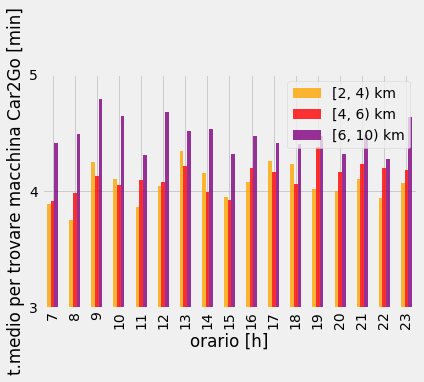

In [3]:
tragitti = tragitti[clean(tragitti)]

tmedio_macchina_week(tragitti, 'Car2Go').plot.bar(color=wcolors, alpha=.8)
plt.ylim(3, 5)
plt.yticks(range(3, 6, 1))
plt.xlabel('orario [h]')
plt.ylabel('t.medio per trovare macchina Car2Go [min]')
plt.show()

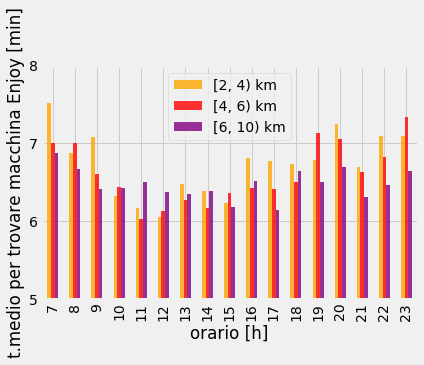

In [4]:
tmedio_macchina_week(tragitti, 'Enjoy').plot.bar(color=wcolors, alpha=.8)
plt.ylim(5, 8)
plt.yticks(range(5, 9, 1))
plt.xlabel('orario [h]')
plt.ylabel('t.medio per trovare macchina Enjoy [min]')
plt.show()

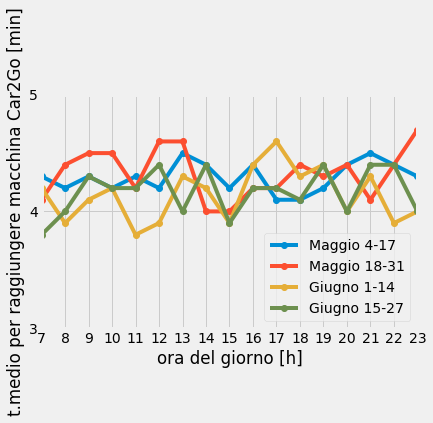

In [5]:
lst = [
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Car2Go'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Car2Go'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Car2Go'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Car2Go')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=range(7,24),
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

confronto_vmedie_week_by_week.plot(marker='o')
plt.ylim(3, 5)
plt.yticks(range(3, 6, 1))
plt.xticks(range(7, 24, 1))
plt.xlabel('ora del giorno [h]')
plt.ylabel('t.medio per raggiungere macchina Car2Go [min]')
plt.show()

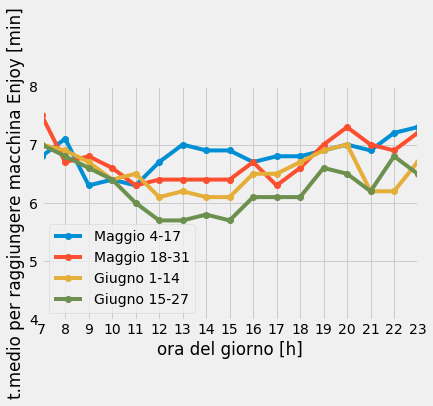

In [6]:
lst = [
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Enjoy'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Enjoy'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Enjoy'),
    tmedio_macchina_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Enjoy')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=range(7,24),
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

confronto_vmedie_week_by_week.plot(marker='o')
plt.ylim(4, 8)
plt.yticks(range(4, 9, 1))
plt.xticks(range(7, 24, 1))
plt.xlabel('ora del giorno [h]')
plt.ylabel('t.medio per raggiungere macchina Enjoy [min]')
plt.show()

In [7]:
def tmedio_week_weekend(df, mezzo):
    sd = 4
    weeks = \
        ((df['Month'] == 5) & (
            (df['Day'].between(sd, sd + 4)) |
            (df['Day'].between(sd + 7, sd + 7 + 4)) |
            (df['Day'].between(sd + 7*2, sd + 7*2 + 4)) |
            (df['Day'].between(sd + 7*3, sd + 7*3 + 4)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1, 1 + 4)) |
            (df['Day'].between(1 + 7, 1 + 7 + 4)) |
            (df['Day'].between(1 + 7*2, 1 + 7*2 + 4)) |
            (df['Day'].between(1 + 7*3, 1+7*3 + 4))))

    weekends = \
        ((df['Month'] == 5) & (
            (df['Day'].between(sd + 5, sd + 5 + 1)) |
            (df['Day'].between(sd + 7 + 5, sd + 7 + 5 + 1)) |
            (df['Day'].between(sd + 7*2 + 5, sd + 7*2 + 5 + 1)) |
            (df['Day'].between(sd + 7*3 + 5, sd + 7*3 + 5 + 1)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1 + 5, 1 + 5 + 1)) |
            (df['Day'].between(1 + 7 + 5, 1 + 7 + 5 + 1)) |
            (df['Day'].between(1 + 7*2 + 5, 1 + 7*2 + 5 + 1)) |
            (df['Day'].between(1 + 7*3 + 5, 1 + 7*3 + 5 + 1))))
        
    lst = [
        tmedio_macchina_giorno(df[weeks], mezzo),
        tmedio_macchina_giorno(df[weekends], mezzo)]
    array = np.array(lst).T
    
    return pd.DataFrame(array, index=range(7,24), columns=['Lun-Ven', 'Sab-Dom']).round(2)

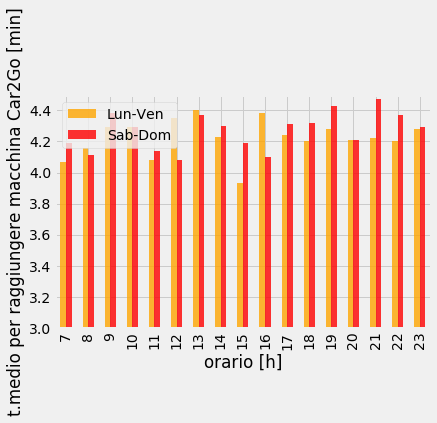

In [8]:
tmedio_week_weekend(tragitti, 'Car2Go').plot.bar(color=wcolors, alpha=.8)
plt.ylim(3, 4.5)
plt.xlabel('orario [h]')
plt.ylabel('t.medio per raggiungere macchina Car2Go [min]')
plt.show()

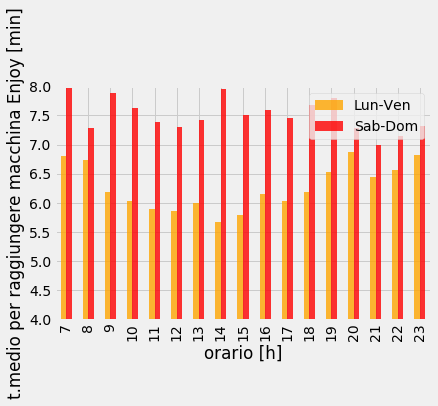

In [9]:
tmedio_week_weekend(tragitti, 'Enjoy').plot.bar(color=wcolors, alpha=.8)
plt.ylim(4, 8)
plt.xlabel('orario [h]')
plt.ylabel('t.medio per raggiungere macchina Enjoy [min]')
plt.show()

In [10]:
df = tragitti
sd = 4
weeks = \
    ((df['Month'] == 5) & (
        (df['Day'].between(sd, sd + 4)) |
        (df['Day'].between(sd + 7, sd + 7 + 4)) |
        (df['Day'].between(sd + 7*2, sd + 7*2 + 4)) |
        (df['Day'].between(sd + 7*3, sd + 7*3 + 4)))) | \
    ((df['Month'] == 6) & (
        (df['Day'].between(1, 1 + 4)) |
        (df['Day'].between(1 + 7, 1 + 7 + 4)) |
        (df['Day'].between(1 + 7*2, 1 + 7*2 + 4)) |
        (df['Day'].between(1 + 7*3, 1+7*3 + 4))))

weekends = \
    ((df['Month'] == 5) & (
        (df['Day'].between(sd + 5, sd + 5 + 1)) |
        (df['Day'].between(sd + 7 + 5, sd + 7 + 5 + 1)) |
        (df['Day'].between(sd + 7*2 + 5, sd + 7*2 + 5 + 1)) |
        (df['Day'].between(sd + 7*3 + 5, sd + 7*3 + 5 + 1)))) | \
    ((df['Month'] == 6) & (
        (df['Day'].between(1 + 5, 1 + 5 + 1)) |
        (df['Day'].between(1 + 7 + 5, 1 + 7 + 5 + 1)) |
        (df['Day'].between(1 + 7*2 + 5, 1 + 7*2 + 5 + 1)) |
        (df['Day'].between(1 + 7*3 + 5, 1 + 7*3 + 5 + 1))))

df[weeks][['Month', 'Day']].drop_duplicates()

,Month,Day
64800,5,4
65880,5,5
66962,5,6
68043,5,7
69122,5,8
72350,5,11
73432,5,12
74510,5,13
80830,5,18
80970,5,19


In [11]:
df[weekends][['Month', 'Day']].drop_duplicates()

,Month,Day
70200,5,9
71290,5,10
85300,5,23
86380,5,24
92841,5,30
93923,5,31
100410,6,6
101490,6,7
107970,6,13
109051,6,14
